# Linear basis function models with PyMC5
**Author - Shubham Bhardwaj**

In [2]:
import logging
import pymc as pm
import numpy as np
import arviz as az

print(pm.__version__)

5.6.1
2.13.0
0.21.0


## Linear basis function models

The following is a PyMC4 implementation of [Bayesian regression with linear basis function models](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-linear-regression/bayesian_linear_regression.ipynb). To recap, a linear regression model is a linear function of the parameters but not necessarily of the input. Input $x$ can be expanded with a set of non-linear basis functions $\phi_j(x)$, where $(\phi_1(x), \dots, \phi_M(x))^T = \boldsymbol\phi(x)$, for modeling a non-linear relationship between input $x$ and a function value $y$.

$$
y(x, \mathbf{w}) = w_0 + \sum_{j=1}^{M}{w_j \phi_j(x)} = w_0 + \mathbf{w}_{1:}^T \boldsymbol\phi(x) \tag{1}
$$

For simplicity I'm using a scalar input $x$ here. Target variable $t$ is given by the deterministic function $y(x, \mathbf{w})$ and Gaussian noise $\epsilon$.

$$
t = y(x, \mathbf{w}) + \epsilon \tag{2}
$$

Here, we can choose between polynomial and Gaussian basis functions for expanding input $x$. 

In [3]:
from functools import partial
from scipy.stats import norm

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=0.3):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)

# Choose between polynomial and Gaussian expansion
# (by switching the comment on the following two lines)
expand = expand_polynomial
#expand = expand_gaussian

For example, to expand two input values `[0.5, 1.5]` into a polynomial design matrix of degree `3` we can use

In [4]:
expand_polynomial(np.array([0.5, 1.5]), degree=3)

array([[0.5  , 0.25 , 0.125],
       [1.5  , 2.25 , 3.375]])

The power of `0` is omitted here and covered by a $w_0$ in the model.

## Example dataset

The example dataset consists of `N` noisy samples from a sinusoidal function `f`.

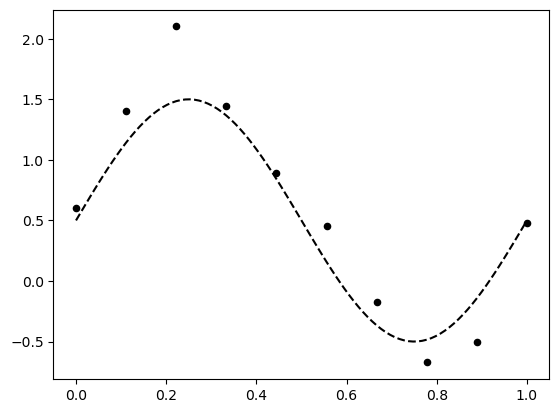

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_linear_regression_util import (
    plot_data, 
    plot_truth
)

def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

# Number of samples
N = 10

# Constant noise 
noise = 0.3

# Noisy samples 
x = np.linspace(0, 1, N, dtype=np.float32)
t = f(x, noise=noise)

# Noise-free ground truth 
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

plot_data(x, t)
plot_truth(x_test, y_true)

## Implementation with PyMC5

### Model definition

The model definition directly follows from Eq. $(1)$ and Eq. $(2)$ with normal priors over parameters. The size of parameter vector `w_r` ($\mathbf{w}_{1:}$ in Eq. $(1)$) is determined by the number of basis functions and set via the `batch_stack` parameter. With the above default settings, it is 3 for polynomial expansion and 9 for Gaussian expansion.

In [34]:
def Model(Phi, t, sigma=noise):
    with pm.Model() as model:
        w_0 = pm.Normal("w_0", mu=0, sigma=10)
        w_r = pm.Normal("w_r", mu=0, sigma=10, shape=Phi.shape[1])
        mu = w_0 + pm.math.dot(w_r, Phi.T)
        t_obs = pm.Normal("t_obs", mu=mu, sigma=sigma, observed=t)
    return model

### Inference

Tensorflow will automatically run inference on a GPU if available. With the current version of PyMC4, inference on a GPU is quite slow compared to a multi-core CPU (need to investigate that in more detail). To enforce inference on a CPU set environment variable `CUDA_VISIBLE_DEVICES` to an empty value. There is no progress bar visible yet during sampling but the following shouldn't take longer than a 1 minute.

In [35]:
model = Model(expand(x), t)
with model:
    trace = pm.sample(draws=1000, chains=3, tune=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w_0, w_r]


Sampling 3 chains for 100 tune and 1_000 draw iterations (300 + 3_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


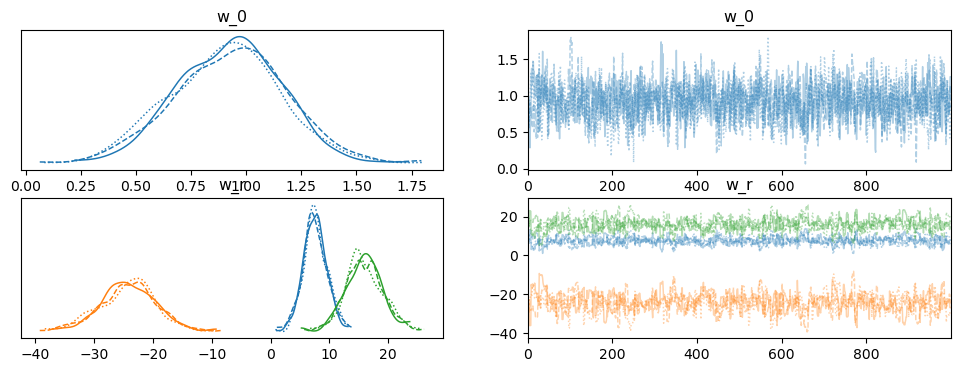

In [36]:
az.plot_trace(trace);

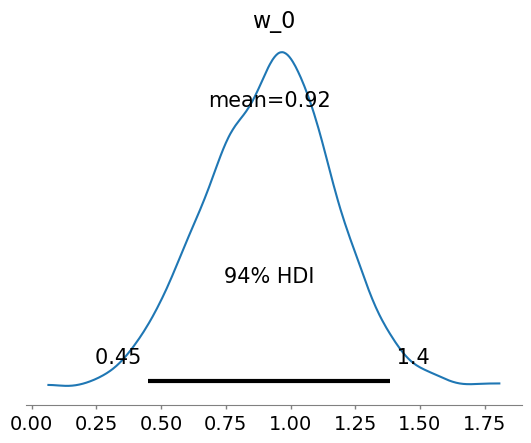

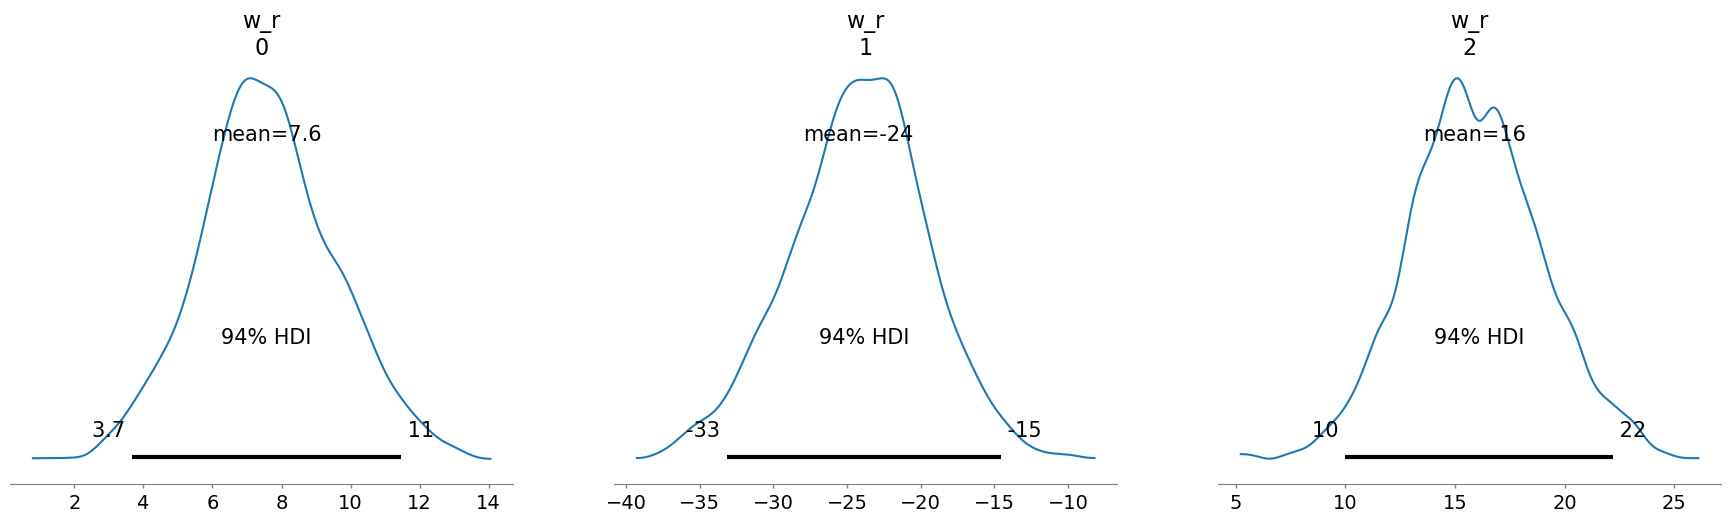

In [38]:
az.plot_posterior(trace, var_names="w_0");
az.plot_posterior(trace, var_names="w_r");

### Prediction

To obtain posterior predictive samples for a test set `x_test` we simply call the model generator function again with the expanded test set. This is a nice improvement over PyMC3 which required to setup a shared Theano variable for setting test set values. Target values are ignored during predictive sampling, only the shape of the target array `t` matters.

In [40]:
model = Model(expand(x_test), t=np.zeros_like(x_test))
with model:
    draws_posterior = pm.sample_posterior_predictive(trace)
draws_posterior.posterior_predictive

Sampling: [t_obs]


<xarray.Dataset>
Dimensions:      (chain: 3, draw: 1000, t_obs_dim_2: 100)
Coordinates:
  * chain        (chain) int64 0 1 2
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * t_obs_dim_2  (t_obs_dim_2) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
Data variables:
    t_obs        (chain, draw, t_obs_dim_2) float64 0.6448 0.9735 ... 0.0725
Attributes:
    created_at:                 2023-08-20T02:21:54.110568
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1

The predictive mean and standard deviation is obtained by averaging over chains (axis `0`) and predictive samples (axis `1`) for each of the 100 data points in `x_test` (axis `2`).

In [42]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['t_obs'].values

m = np.mean(predictive_samples, axis=(0, 1))
s = np.std(predictive_samples, axis=(0, 1))

These statistics can be used to plot model predictions and their uncertainties (together with the ground truth and the noisy training dataset).

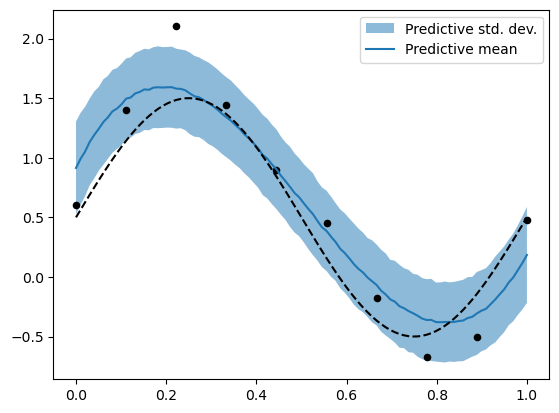

In [43]:
plt.fill_between(x_test, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x_test, m, label='Predictive mean');

plot_data(x, t)
plot_truth(x_test, y_true, label=None)

plt.legend();

Try running the example again with Gaussian expansion i.e. setting `expand = expand_gaussian` and see how it compares to polynomial expansion. Also try running with a different number of basis functions by overriding the default arguments of `expand_polynomial` and `expand_gaussian`. You can find more PyMC4 examples in the [notebooks](https://github.com/pymc-devs/pymc4/tree/master/notebooks) diretory of the PyMC4 project.